In [1]:
from sklearn.decomposition import PCA
import cv2, os
from scipy.io import loadmat

import numpy as np
import matplotlib.pyplot as plt
import cv2, os
from scipy import ndimage
import torch
from tqdm import tqdm

In [2]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작
proj_H, proj_W = 360, 640

m_n = 3
wvls_n = 24
n_patches = 24
n_channel = 3

patch_size = 3

In [3]:
data = "hdr_datas"
illum_name = "line_pattern_5"

data_dir = '../dataset/%s/'%data
illum_dir = '../dataset/image_formation/illum/%s/'%illum_name

n_illum = len(os.listdir(illum_dir))

## Illumination picking

### Make mask, idx

In [4]:
# illums = np.array([cv2.imread(os.path.join('../dataset/image_formation/illum/line_pattern_5', 'illum_%03d.png'%i),-1)/255 for i in range(318)])

# illum_idx = np.zeros(shape = (proj_W,), dtype = np.int16)

# for i in range(n_illum):
#     illum_idx[i*2:i*2 + 2] = i
#     if i == 317:
#         illum_idx[i*2:] = i
        
# uv1 = np.load('../dataset/uv1.npy') # m, wvl, uv1, # of pixel
# valid_mask = (np.round(uv1[:,:,0]) > 0) & (np.round(uv1[:,:,0]) < 640) & (np.round(uv1[:,:,1]) > 0) & (np.round(uv1[:,:,1]) < 360)

# valid_mask = valid_mask.flatten() # m, wvl, # px
# uv1 = uv1.transpose(0,1,3,2).reshape(-1, 3) # m, wvl, # px, uv1

# valid_idx = np.zeros(shape=(m_n, wvls_n, cam_H, cam_W)).flatten()
# for k in tqdm(range(m_n*wvls_n*cam_H*cam_W)):
#     if valid_mask[k] == True:
#         valid_idx[k] = illum_idx[np.round(uv1[k,0]).astype(np.int16)]

In [5]:
# np.save('valid_idx.npy', valid_idx)
# np.save('valid_mask.npy', valid_mask)

### Load

In [6]:
valid_idx = np.load('valid_idx.npy')
valid_mask = np.load('valid_mask.npy')

In [7]:
valid_idx[~valid_mask] = -1
valid_idx_final = valid_idx.reshape(m_n, wvls_n, cam_H, cam_W)

In [8]:
valid_mask_reshape = valid_mask.reshape(m_n, wvls_n, cam_H, cam_W)

In [9]:
# valid_mask_reshape[2,:,100,100], valid_idx_final[2,:,200,300]

## Make HDR data

In [10]:
idx_minmax = 1

fn_exp = np.array([160, 320])

# exposure times
ex_time = np.array([0.1, 0.9])
ex_min = ex_time[idx_minmax]
exposure = ex_time / ex_min

In [11]:
invalid_intensity_ratio = 0.01 # 0 < invalid_intensity_ratio: invalid,  out of 1

max_intensity = 2**8
weight_trapezoid = np.zeros(max_intensity)
intv = float(max_intensity) * invalid_intensity_ratio

for i in range(max_intensity):
    if i < intv:
        weight_trapezoid[i] = 0  
    elif i < intv * 2:
        weight_trapezoid[i] = (i - intv) / intv
    elif i < max_intensity - (intv * 2):
        weight_trapezoid[i] = 1
    elif i < max_intensity - intv:
        weight_trapezoid[i] = (max_intensity - intv - i) / intv
    else:
        weight_trapezoid[i] = 0

In [12]:
def make_hdr(ldr_images, weight_trapezoid, exposure):

    weighted_images = [weight_trapezoid[image] for image in ldr_images]
    
    # exposure normalization
    radiance_images = [np.multiply(weighted_images[i], ldr_images[i] / (exposure[i])) for i in range(len(ldr_images))]

    # intensity normalization
    weight_sum_image = np.sum(weighted_images, axis=0)
    radiance_sum_image = np.sum(radiance_images, axis=0)

    idx_invalid = (weight_sum_image == 0)
    weight_sum_image[idx_invalid] = 1
    radiance_sum_image[idx_invalid] = 0    
    
    return np.divide(radiance_sum_image, weight_sum_image), idx_invalid, weight_sum_image

In [13]:
hdr_imgs = np.zeros(shape = (n_illum, cam_H, cam_W, 3))

# erase black image and get hdr image
for i in range(n_illum):   
    ldr_path = os.path.join(data_dir, 'step2_%sms_crop/capture_%04d.png')
    
    ldr_images = np.array([cv2.imread(ldr_path%(k, i), -1)[:,:,::-1] for k in fn_exp]) 
            
    hdr_img, invalid_map, weight_map = make_hdr(ldr_images, weight_trapezoid, exposure)
    hdr_imgs[i] = hdr_img
    
    if i % 10 == 0:
        print('%03d-th finished'%i)

hdr_imgs = np.array(hdr_imgs)

000-th finished
010-th finished
020-th finished
030-th finished
040-th finished
050-th finished
060-th finished
070-th finished
080-th finished
090-th finished
100-th finished
110-th finished
120-th finished
130-th finished
140-th finished
150-th finished
160-th finished
170-th finished
180-th finished
190-th finished
200-th finished
210-th finished
220-th finished
230-th finished
240-th finished
250-th finished
260-th finished
270-th finished
280-th finished
290-th finished
300-th finished
310-th finished


In [14]:
idx = 2
plt.imshow(hdr_imgs[idx]/(255)) # 0.9 / 0.1 = 9

In [15]:
if data == "ours":
    plt.figure(figsize=(3,2))
    plt.ylim([0,1])
    plt.plot(hdr_imgs[:,300,700]/255)

## Hyperspectral Reconstruction

### PEF, CRF, DG

In [16]:
PEF = np.load('../dataset/image_formation/PEF_update.npy')[::2]
CRF = np.load('../dataset/image_formation/CRF_update.npy')[::2] # from 430nm
DG_efficiency = np.load('../dataset/image_formation/DG_update.npy')[:,::2] # from 430nm
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 24) # 400 ~ 680 까지 10nm 간격으로

In [17]:
PEF.shape, CRF.shape, DG_efficiency.shape

((24, 3), (24, 3), (3, 24))

In [18]:
# # load original hdr data
hdr_imgs = hdr_imgs / 255

# median filter
hdr_imgs_filtered_R = np.array([ndimage.median_filter(image[:,:,0], size=4) for image in hdr_imgs])
hdr_imgs_filtered_G = np.array([ndimage.median_filter(image[:,:,1], size=4) for image in hdr_imgs])
hdr_imgs_filtered_B = np.array([ndimage.median_filter(image[:,:,2], size=4) for image in hdr_imgs])

hdr_imgs_filtered = np.stack((hdr_imgs_filtered_R, hdr_imgs_filtered_G, hdr_imgs_filtered_B), axis = 3)

hdr_imgs = hdr_imgs_filtered

In [19]:
plt.figure(figsize=(5,3))
plt.imshow(hdr_imgs[5])

### bring depth

In [20]:
depth = np.load(os.path.join(data_dir,'depth.npy'))*1e+3

(<Figure size 300x200 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1ba590f9448>)

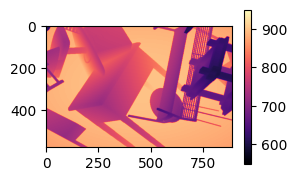

In [21]:
plt.figure(figsize=(3,2)), plt.imshow(depth, vmin = 550, vmax = 950, cmap='magma'), plt.colorbar()

In [22]:
depth = np.round(depth).reshape(cam_H* cam_W).astype(np.int16)

### Get mask

In [23]:
# Define valid illumination indexing function

In [24]:
valid_idx_final.shape, valid_mask_reshape.shape

((3, 24, 580, 890), (3, 24, 580, 890))

In [25]:
zero_real_img_illum_idx = valid_idx_final[1,0]

first_real_img_illum_idx =  np.zeros(shape=(wvls_n, cam_H *cam_W))

valid_idx_final = valid_idx_final.reshape(m_n, wvls_n, cam_H*cam_W)

In [26]:
for i in range(cam_H * cam_W):
    if -1 in valid_idx_final[0,:,i]:
        if -1 in valid_idx_final[2,:,i]:
            m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
            f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
            if m_count > f_count:
                first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
            else:
                first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
    
    elif -1 in valid_idx_final[2,:,i]:
        if -1 in valid_idx_final[0,:,i]:
            m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
            f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
            if m_count > f_count:
                first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
            else:
                first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
              
    else:
        m_count = np.count_nonzero(valid_idx_final[0,:,i] == -1) 
        f_count = np.count_nonzero(valid_idx_final[2,:,i] == -1)
        if m_count > f_count:
            first_real_img_illum_idx[:,i] = valid_idx_final[0,:,i]
        else:
            first_real_img_illum_idx[:,i] = valid_idx_final[2,:,i]

In [27]:
mask_idx = np.ones(shape=(len(new_wvls), cam_H*cam_W))
first_real_img_illum_idx_reshape =  first_real_img_illum_idx.reshape(wvls_n, cam_H*cam_W)

for i in range(cam_W*cam_H):
    if -1 in first_real_img_illum_idx[:,i]:
        idx = np.where(first_real_img_illum_idx[:,i] == -1)[0]
        first_real_img_illum_idx[idx,i] = first_real_img_illum_idx[idx[0]-1,i]
        mask_idx[idx,i] = 0

In [28]:
zero_real_img_illum_idx.shape

(580, 890)

In [29]:
first_real_img_illum_idx_final = np.repeat(first_real_img_illum_idx[:,:,np.newaxis], 3, axis = 2)
zero_real_img_illum_idx_final = np.repeat(zero_real_img_illum_idx.reshape(cam_W*cam_H)[:,np.newaxis], 3, axis = 1)

first_real_img_illum_idx_final = first_real_img_illum_idx_final.astype(np.int16).reshape(wvls_n, cam_H, cam_W, 3)
zero_real_img_illum_idx_final = zero_real_img_illum_idx_final.astype(np.int16).reshape(cam_H, cam_W, 3)[np.newaxis,:,:,:]

In [30]:
white_pattern = np.ones(shape = (1, 3)) * 0.8
white_pattern_hyp = white_pattern @ PEF.T

x, y, z = np.meshgrid(np.arange(580), np.arange(890), np.arange(3), indexing='ij')

GT_I_RGB_FIRST = hdr_imgs[first_real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)   
GT_I_RGB_ZERO =  hdr_imgs[zero_real_img_illum_idx_final, x, y, z].transpose(1, 2, 0, 3)

In [31]:
first_real_img_illum_idx_reshape = first_real_img_illum_idx.reshape(len(new_wvls), cam_H*cam_W)
zero_real_img_illum_idx_flatt = zero_real_img_illum_idx.flatten()
# DG efficiency for all pixels
DG_efficiency_image_first = np.zeros(shape=(cam_H * cam_W, len(new_wvls)))
DG_efficiency_image_zero = np.ones(shape=(cam_H * cam_W, len(new_wvls))) # * (max(DG_efficiency[0].sum(), DG_efficiency[2].sum()) / 47)

dg_scalar = 1+0.5*(DG_efficiency[2]-DG_efficiency[0])

for i in tqdm(range(cam_H * cam_W)):
    if zero_real_img_illum_idx_flatt[i] > first_real_img_illum_idx_reshape[0,i]: # 430nm # -1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[0]
    elif zero_real_img_illum_idx_flatt[i] < first_real_img_illum_idx_reshape[0,i]: # +1 order
        DG_efficiency_image_first[i,:] =  DG_efficiency[2]  #dg_scalar
    else: # else
        DG_efficiency_image_first[i,:] = 0

  0%|          | 0/516200 [00:00<?, ?it/s]

100%|██████████| 516200/516200 [00:00<00:00, 1433901.65it/s]


### Simulation

In [32]:
pts = np.array([np.random.randint(0, cam_W, 20), np.random.randint(0, cam_H, 20)]).T

In [33]:
hyp_gt = np.load(os.path.join(data_dir, 'hyp_gt.npy'))

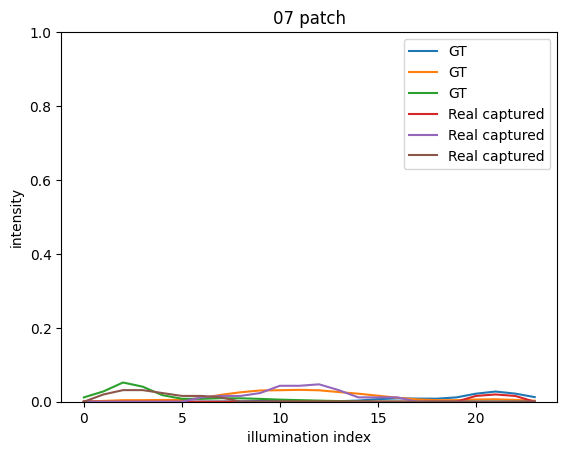

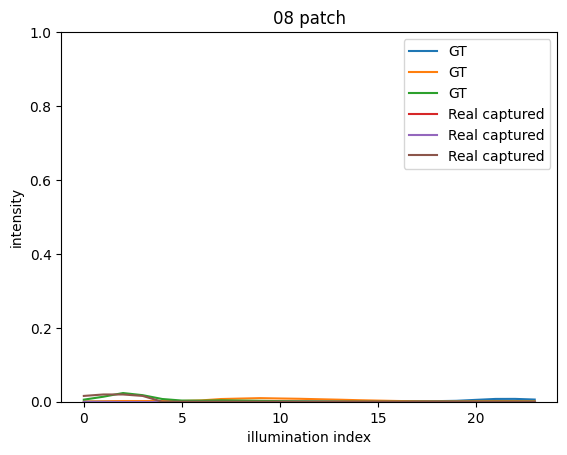

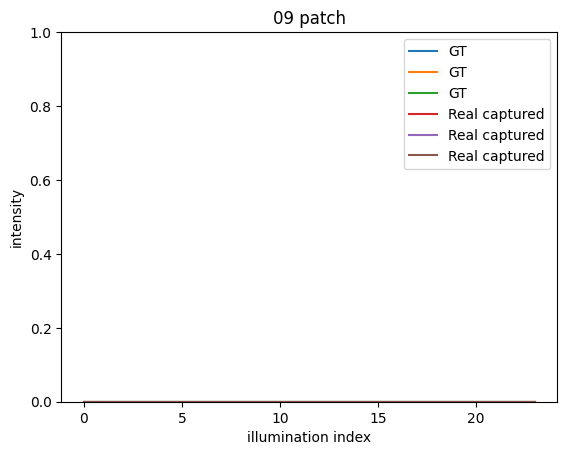

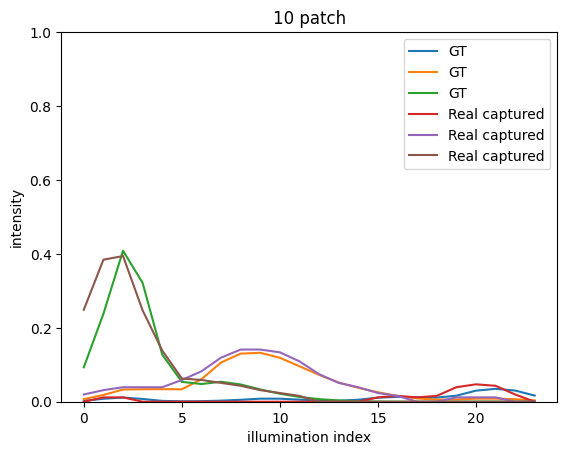

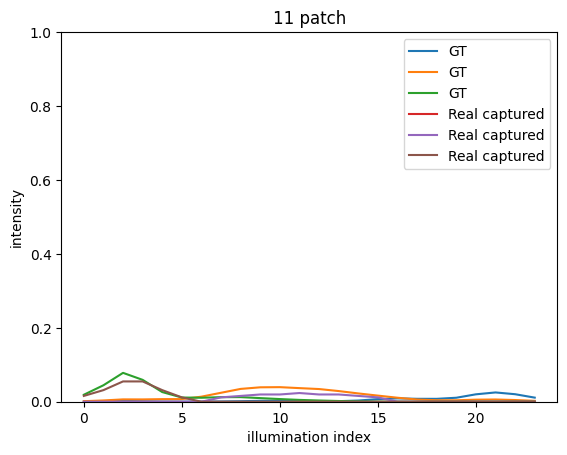

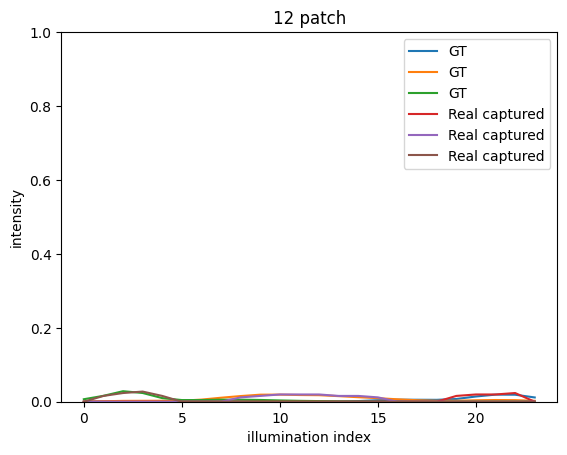

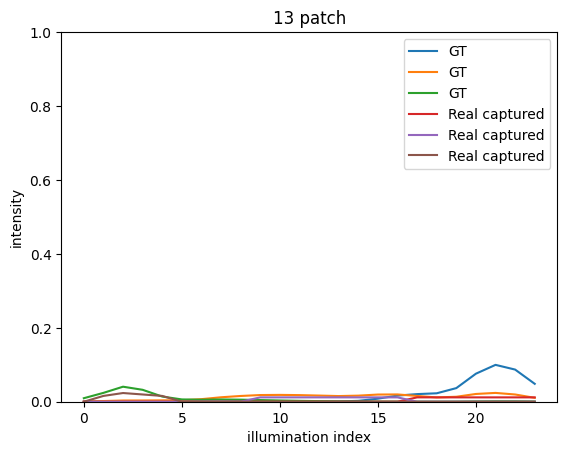

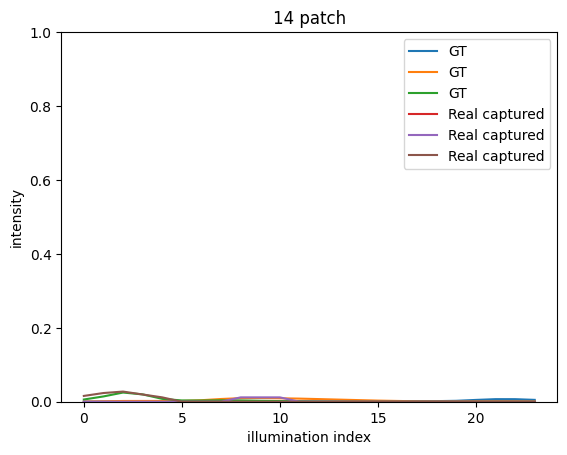

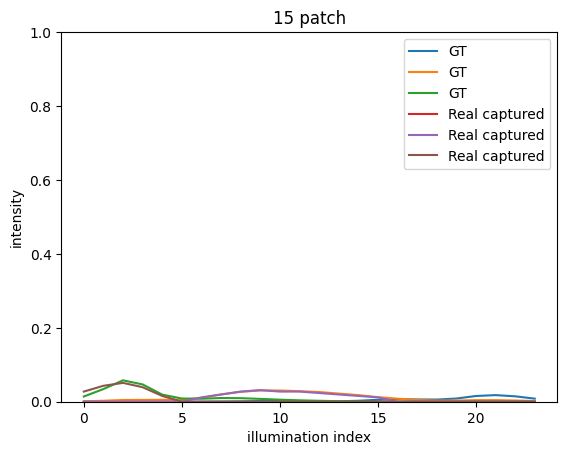

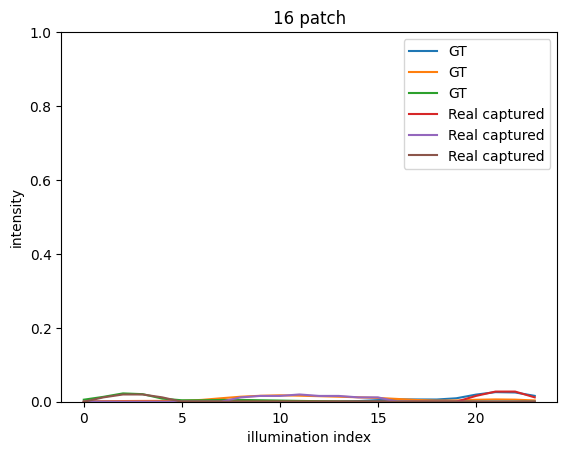

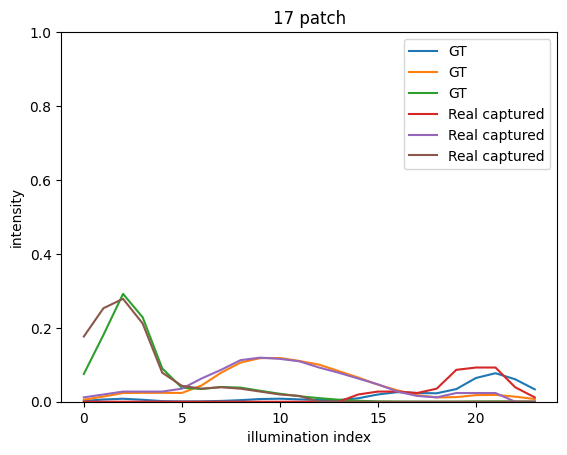

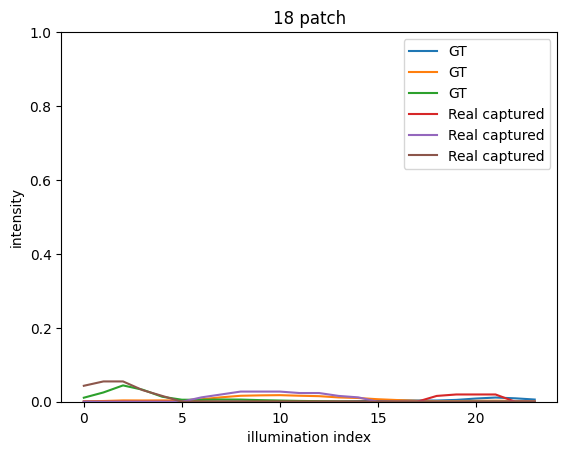

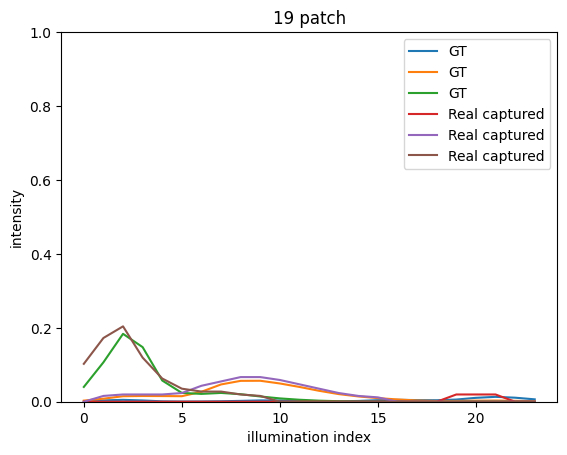

In [34]:
DG_efficiency_image_reshape = DG_efficiency_image_first.reshape(cam_H, cam_W, wvls_n)

for i in range(len(pts)):
        plt.figure()
        plt.ylim([0,1])
        plt.xlabel('illumination index')
        plt.ylabel('intensity')
        
        dg = DG_efficiency_image_reshape[pts[i,1],pts[i,0]][:,np.newaxis]
        
        plt.plot((hyp_gt[pts[i,1],pts[i,0]][:,np.newaxis] * white_pattern_hyp.transpose(1,0) * dg) * CRF, label= 'GT')
        plt.plot(GT_I_RGB_FIRST[pts[i,1],pts[i,0]], label = "Real captured")

        plt.legend()
        plt.title('%02d patch'%i)

### Optimization Ours

In [35]:
# Make all wavelength invalid if one wavelength is invalid
for i in range(cam_H*cam_W):
    if 0 in mask_idx[:,i]:
        mask_idx[:,i] = 0

In [36]:
mask = np.zeros((cam_H, cam_W, len(new_wvls), 1))
mask_temp = mask_idx.T.reshape(cam_H, cam_W, len(new_wvls), 1)
for i in range(24):
    a = mask_temp[:,:,i,:]
    sigma = 150

    dst = cv2.GaussianBlur(a, (0,0), sigma)
    mask[:,:,i,:] = torch.tensor(dst[...,None])

unreached_mask_tensor = torch.tensor(mask, device='cuda:0')

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch : 0/600, Loss: 20.907657201232286, LR: 0.04


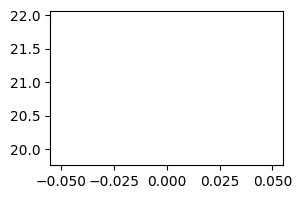

Epoch : 10/600, Loss: 16.0589423299675, LR: 0.04
Epoch : 20/600, Loss: 11.78447135977242, LR: 0.04
Epoch : 30/600, Loss: 8.390461097849641, LR: 0.04
Epoch : 40/600, Loss: 5.903338974661014, LR: 0.04
Epoch : 50/600, Loss: 4.253570221740742, LR: 0.04
Epoch : 60/600, Loss: 3.1816078555773246, LR: 0.04
Epoch : 70/600, Loss: 2.4797238401458075, LR: 0.04
Epoch : 80/600, Loss: 2.0173480998735602, LR: 0.04
Epoch : 90/600, Loss: 1.7040089317243035, LR: 0.04
Epoch : 100/600, Loss: 1.485230719974581, LR: 0.04


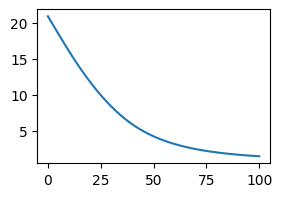

Epoch : 110/600, Loss: 1.327177763483558, LR: 0.04
Epoch : 120/600, Loss: 1.2102313198048962, LR: 0.04
Epoch : 130/600, Loss: 1.1222652253004535, LR: 0.04
Epoch : 140/600, Loss: 1.0545337097952112, LR: 0.04
Epoch : 150/600, Loss: 1.0009347583880874, LR: 0.04
Epoch : 160/600, Loss: 0.957812401271553, LR: 0.04
Epoch : 170/600, Loss: 0.9225879698451179, LR: 0.04
Epoch : 180/600, Loss: 0.8934840540699276, LR: 0.04
Epoch : 190/600, Loss: 0.869133946060475, LR: 0.04
Epoch : 200/600, Loss: 0.8486109930076106, LR: 0.04


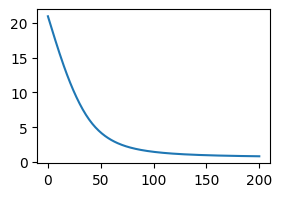

Epoch : 210/600, Loss: 0.8312171594407909, LR: 0.04
Epoch : 220/600, Loss: 0.816438590395469, LR: 0.04
Epoch : 230/600, Loss: 0.8036302874921393, LR: 0.04
Epoch : 240/600, Loss: 0.7926260632416018, LR: 0.04
Epoch : 250/600, Loss: 0.7830785200931107, LR: 0.04
Epoch : 260/600, Loss: 0.7746746372418603, LR: 0.04
Epoch : 270/600, Loss: 0.7673324424341197, LR: 0.04
Epoch : 280/600, Loss: 0.760829506189823, LR: 0.04
Epoch : 290/600, Loss: 0.7549850602790652, LR: 0.04
Epoch : 300/600, Loss: 0.7497607380185976, LR: 0.04


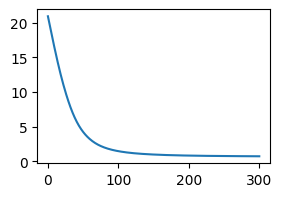

Epoch : 310/600, Loss: 0.7451590837052346, LR: 0.04
Epoch : 320/600, Loss: 0.7409559512282384, LR: 0.04
Epoch : 330/600, Loss: 0.7371540215843321, LR: 0.04
Epoch : 340/600, Loss: 0.7336914352890547, LR: 0.04
Epoch : 350/600, Loss: 0.7305412846460158, LR: 0.04
Epoch : 360/600, Loss: 0.727607967492969, LR: 0.04
Epoch : 370/600, Loss: 0.7249449694302876, LR: 0.04
Epoch : 380/600, Loss: 0.7224649500986778, LR: 0.04
Epoch : 390/600, Loss: 0.720199227978759, LR: 0.04
Epoch : 400/600, Loss: 0.7180968362428563, LR: 0.02


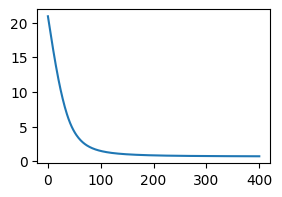

Epoch : 410/600, Loss: 0.7130369976483517, LR: 0.02
Epoch : 420/600, Loss: 0.7112414734711093, LR: 0.02
Epoch : 430/600, Loss: 0.7099905783399173, LR: 0.02
Epoch : 440/600, Loss: 0.7089880328916596, LR: 0.02
Epoch : 450/600, Loss: 0.7080622962412567, LR: 0.02
Epoch : 460/600, Loss: 0.7071993500689238, LR: 0.02
Epoch : 470/600, Loss: 0.7063570326959514, LR: 0.02
Epoch : 480/600, Loss: 0.7055451998398844, LR: 0.02
Epoch : 490/600, Loss: 0.70474129743872, LR: 0.02
Epoch : 500/600, Loss: 0.7039783323644075, LR: 0.02


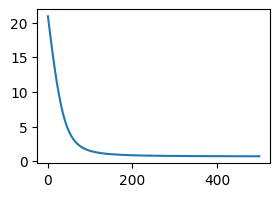

Epoch : 510/600, Loss: 0.7032191720387999, LR: 0.02
Epoch : 520/600, Loss: 0.7024846214841742, LR: 0.02
Epoch : 530/600, Loss: 0.7017795551790363, LR: 0.02
Epoch : 540/600, Loss: 0.7010716733167137, LR: 0.02
Epoch : 550/600, Loss: 0.7003868588527659, LR: 0.02
Epoch : 560/600, Loss: 0.699719863908711, LR: 0.02
Epoch : 570/600, Loss: 0.69909348523923, LR: 0.02
Epoch : 580/600, Loss: 0.6984624882168999, LR: 0.02
Epoch : 590/600, Loss: 0.6978342614471246, LR: 0.02


In [87]:
import random
# arguments
device = 'cuda:0'
epoch = 600 #2000
loss_f = torch.nn.L1Loss()
losses = [] 

# learning rate & decay step
lr = 0.04 # 0.03
decay_step = 400
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(cam_H*cam_W, len(new_wvls)))/2
initial_value = torch.logit(initial_value)
_opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([_opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF_dev = torch.tensor(PEF, dtype = torch.float).to(device).T
CRF_dev = torch.tensor(CRF, dtype = torch.float).to(device)
DG_efficiency_first_dev = torch.tensor(DG_efficiency_image_first.reshape(cam_H*cam_W, -1), device= device) # H x W, wvls
DG_efficiency_zero_dev = torch.tensor(DG_efficiency_image_zero.reshape(cam_H*cam_W, -1), device=device)

# depth scalar
A =  3.5 * 1e+5 # 10 * 1e+5 for peak # 4 * 1e+5 for tree
depth_scalar = ((depth.astype(np.int32))**2) / A

depth_scalar_dev = torch.tensor(depth_scalar, dtype = torch.float).to(device).T
# depth_scalar_dev = torch.ones_like(torch.tensor(depth_scalar), dtype = torch.float).to(device).T
# unreached_mask_tensor = torch.tensor(mask_idx.T, device=device).reshape(cam_H, cam_W, 47, 1)

# white pattern into multi-spectral channels
white_patt = torch.ones(size = (cam_H * cam_W, 3), device=device) * 0.8
white_patt_hyp = white_patt @ PEF_dev
white_patt_hyp = white_patt_hyp.squeeze()

GT_I_RGB_FIRST_tensor = torch.tensor(GT_I_RGB_FIRST, device=device)
GT_I_RGB_ZERO_tensor = torch.tensor(GT_I_RGB_ZERO, device=device)

rand_idx = [random.randint(0, 21) for _ in range(5)]

weight_first = 1
weight_zero = 0
weight_unreach = 1
weight_spectral = 40 # 50

loss_vis = []
A_first = CRF_dev.unsqueeze(dim = 0) * white_patt_hyp.unsqueeze(dim = -1) * DG_efficiency_first_dev.unsqueeze(dim = -1)
A_zero = CRF_dev.unsqueeze(dim = 0) * white_patt_hyp.unsqueeze(dim = -1) * DG_efficiency_zero_dev.unsqueeze(dim = -1)

for i in range(epoch):
    # initial loss
    loss = 0

    opt_param = torch.sigmoid(_opt_param)
    # opt_param.data = torch.clamp(opt_param.data, min=0)

    Simulated_I_RGB_first = opt_param.unsqueeze(dim = -1) * A_first / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1) 
    Simulated_I_RGB_zero = torch.sum(opt_param.unsqueeze(dim = -1) * A_zero / depth_scalar_dev.unsqueeze(dim = -1).unsqueeze(dim = -1), axis=1) 
    
    image_loss_first = torch.abs((Simulated_I_RGB_first.reshape(cam_H, cam_W, len(new_wvls), 3)) - GT_I_RGB_FIRST_tensor) * unreached_mask_tensor / (cam_H*cam_W)
    loss += weight_first * image_loss_first.sum()

    unreached_loss = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor) * (1 - unreached_mask_tensor) / (cam_H*cam_W)
    # image_loss_zero = torch.abs((Simulated_I_RGB_zero.reshape(cam_H, cam_W, 1, 3)) - GT_I_RGB_ZERO_tensor) / (cam_H*cam_W)
    
    # loss += (weight_zero * image_loss_zero.sum() + weight_unreach*unreached_loss.sum())
    loss +=  weight_unreach*unreached_loss.sum()
    
    hyp_dL2 = ((opt_param[:,:-1] - opt_param[:,1:])**2).sum()/(cam_H*cam_W)
    loss += weight_spectral*(hyp_dL2)

    loss = loss.sum()
    loss_vis.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    scheduler.step()
        
    if i % 10 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
        
        if i % 100 == 0:
            plt.figure(figsize=(3,2))
            plt.plot(loss_vis) #, plt.title(f"Epoch : {i}/{epoch}, Loss: {loss.item()}, LR: {optimizer.param_groups[0]['lr']}")
            plt.show()

### Optimization Procam

### Visualization

In [88]:
opt_param_detach = opt_param.detach().cpu().numpy()

In [89]:
np.save('../opt_param_ours.npy', opt_param_detach.reshape(cam_H, cam_W, wvls_n))

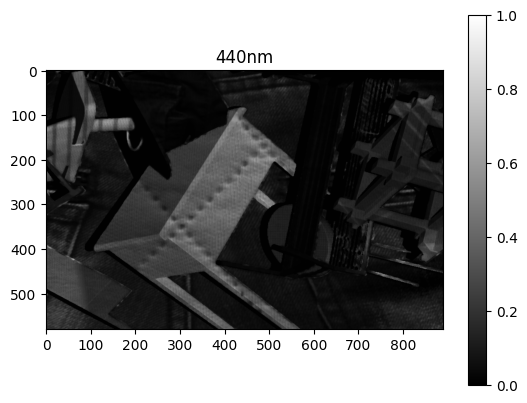

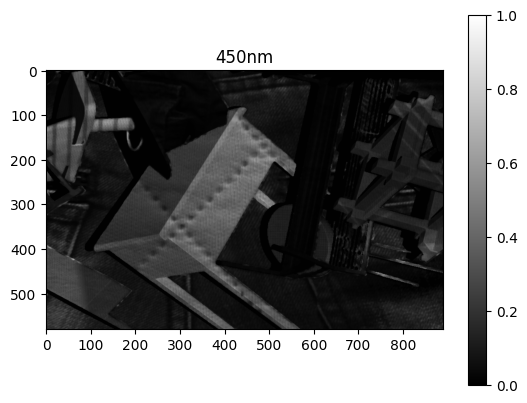

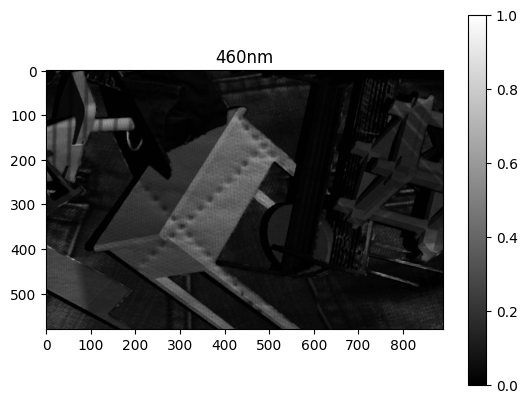

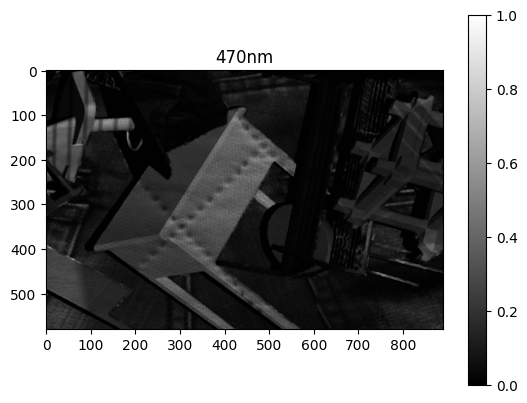

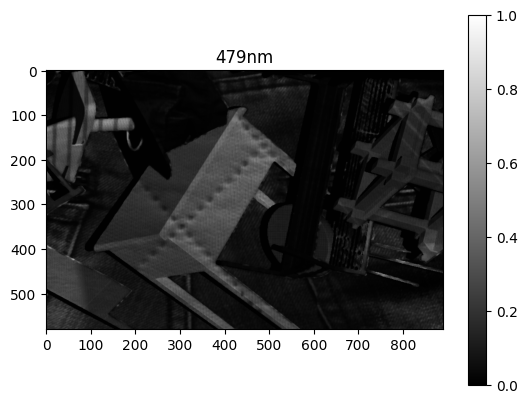

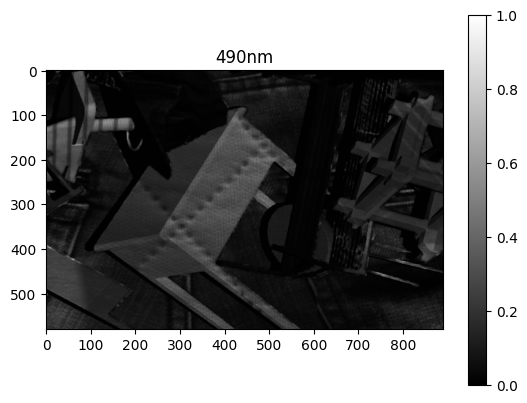

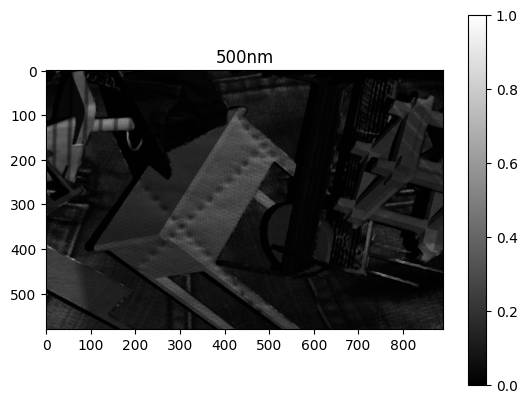

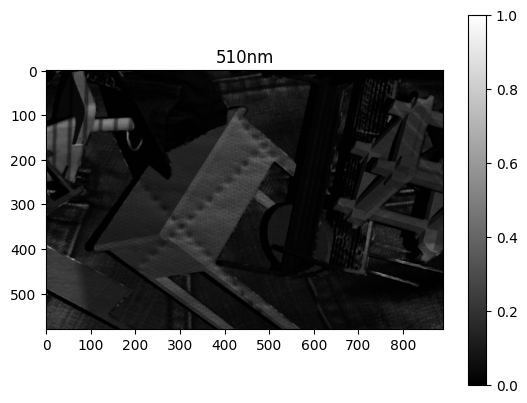

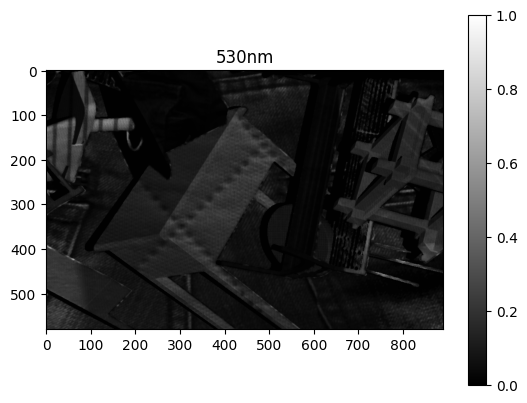

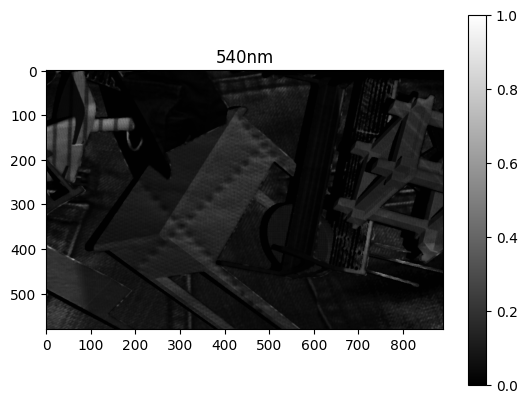

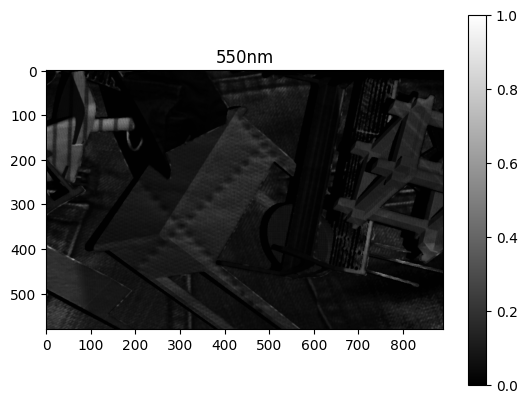

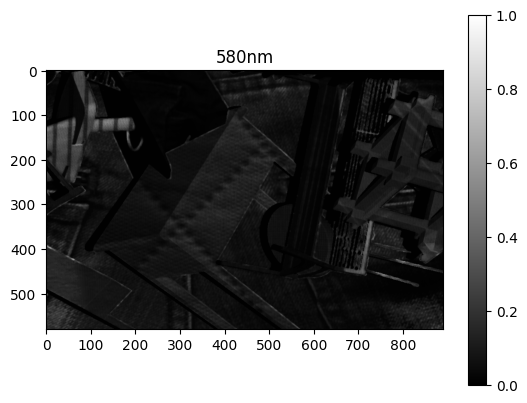

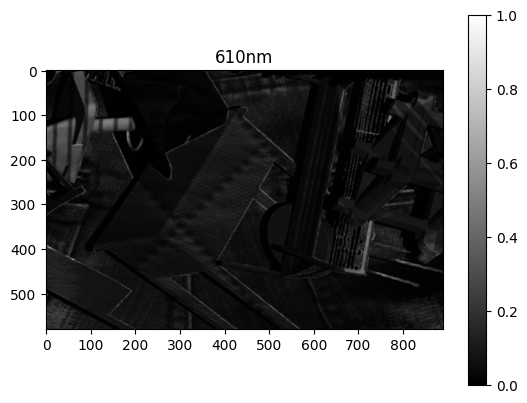

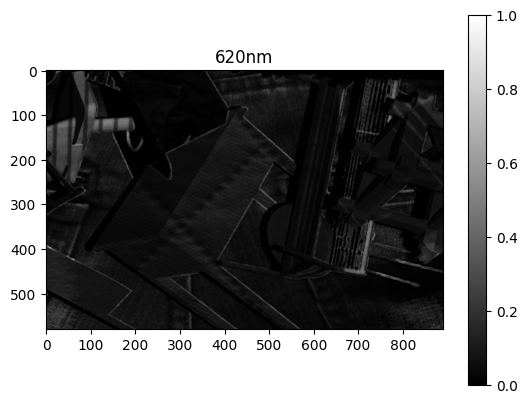

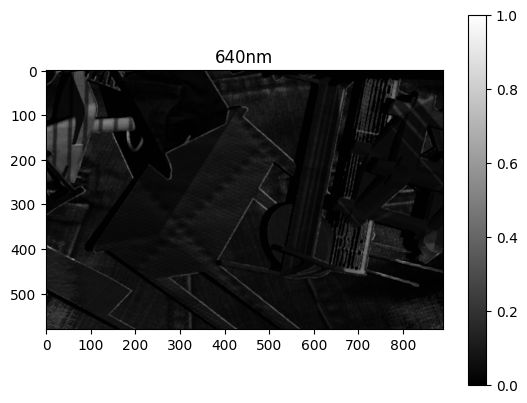

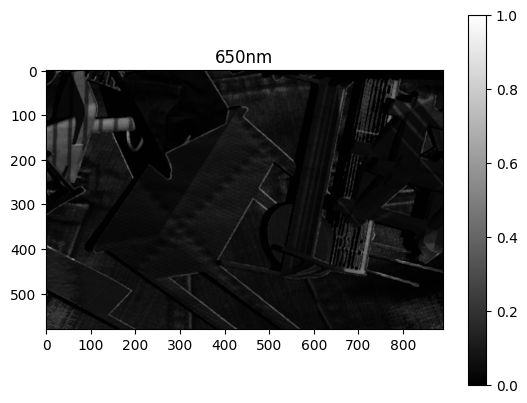

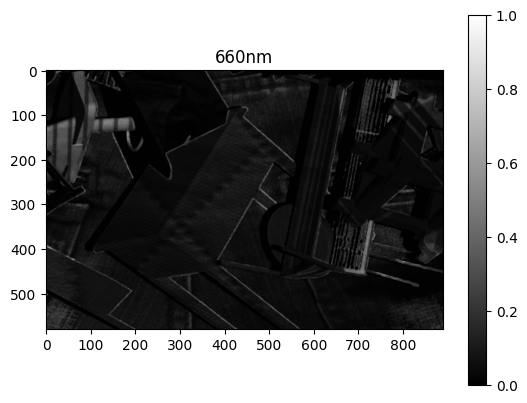

In [90]:
wvl_title = (new_wvls*1e9).to(torch.int16)
a = (opt_param_detach[..., np.newaxis])

for i in range(len(new_wvls)):
    plt.imshow(a[:,i].reshape(cam_H, cam_W, -1), vmin = 0, vmax=1, cmap = 'gray'), plt.title('%dnm'%wvl_title[i]), plt.colorbar()
    plt.show()

### Compare GT

In [91]:
hyp_gt = np.array([cv2.imread('../CASSI/hyp_shading_gt/%02d.png'%i,-1)/255 for i in range(wvls_n)])

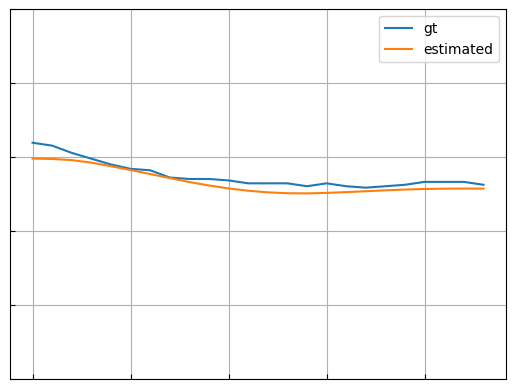

In [92]:
H, W = 120, 140
# H, W = 58, 664
# H, W = 300, 200
# H, W = 155, 120

fig, ax = plt.subplots()
plt.ylim([0,1])
plt.plot(hyp_gt[:,H,W], label = 'gt')
plt.plot(opt_param_detach.reshape(cam_H, cam_W, wvls_n)[H,W], label = 'estimated')
plt.legend()
plt.grid()

# Erasing y-axis and x-axis labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Setting ticks direction to inward
ax.tick_params(axis='x', direction='in')
ax.tick_params(axis='y', direction='in')

In [93]:
# np.save('../opt_param_ours.npy', opt_param_detach.reshape(580, 890, len(new_wvls)))

rgb_img = (opt_param_detach.reshape(580, 890, len(new_wvls)))@CRF

plt.figure()
plt.imshow(rgb_img*0.1)
# plt.savefig('./rgb.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


### Imshow

In [94]:
# from scipy.io import savemat

# savemat('../CASSI/x_recon.mat', {'x_recon':opt_param.detach().cpu().numpy().reshape(580, 890, len(new_wvls))})